# Importar librerias necesarias

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
!pip install kaggle

In [3]:
from google.colab import files
uploaded = files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
!kaggle datasets download -d sachinkumar413/alzheimer-mri-dataset

 43% 12.0M/28.0M [00:00<00:00, 114MB/s]
100% 28.0M/28.0M [00:00<00:00, 160MB/s]


In [5]:
! mkdir all_data

In [ ]:
! unzip /content/alzheimer-mri-dataset.zip -d all_data

# Descripción conjuto de datos


Se seleccionó una base de datos de la plataforma kaggle correspondiente a
imágenes de resonancia magnética del cerebro de diferentes pacientes con ALzheimer y sin Alzheimer.

El dataset consiste en 4 clases: 'Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented'

Se pretende hacer un modelo que pueda detectar  partir de las imágenes  de RM si tiene Alzheimer y de ser ese el caso, en qué etapa de su desarrollo de encuentra.

La detección temprana de Alzheimer permite iniciar intervenciones y tratamientos lo antes posible, lo que puede ayudar a ralentizar la progresión de la enfermedad y mejorar la calidad de vida de los afectados.
Así, mediante las imágenes de RM el modelo puede aprender a detectar cambios en la estructura del cerebro, como la reducción del tamaño del hipocampo, una región cerebral asociada con la memoria.

Dado que los datos vienen separados en 4 carpetas, cada una correspondiente a una clase, se realizó el siguiente código para separar entre train,test y validation.

De esta manera las base de datos se clasificará en 3 carpetas (train,test y validation), que a su vez se dividará en 4 subcarpetas más ('Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented'). Así tendremo 1280 fotos para test, 1280 fotos para validation y 4605 fotos para train.

In [7]:
import os
from sklearn.model_selection import train_test_split
import shutil
from pathlib import Path
dataset_path =Path('/content/all_data/Dataset')
train_path =Path('/content/all_data/Dataset_modelo/train')
val_path = Path('/content/all_data/Dataset_modelo/validation')
test_path = Path('/content/all_data/Dataset_modelo/test')
#Crear dir correspondientes
os.makedirs('/content/all_data/Dataset_modelo/train', exist_ok=True)
os.makedirs('/content/all_data/Dataset_modelo/test', exist_ok=True)
os.makedirs('/content/all_data/Dataset_modelo/validation', exist_ok=True)

In [8]:
classes = os.listdir(dataset_path)
for alz_class in classes:
    class_path = os.path.join(dataset_path, alz_class)
    images = os.listdir(class_path)
    #dividir train en train y test
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

    # Dividir el set de train en train y val
    train_images, val_images = train_test_split(train_images, test_size=0.1, random_state=42)

    # Move images to the respective directories
    for image in train_images:
        source = os.path.join(class_path, image)
        dest = os.path.join(train_path, alz_class, image) #train -> clase -> imagen
        os.makedirs(os.path.dirname(dest), exist_ok=True) #crea el destino por si no existe
        shutil.copy(source, dest)

    for image in val_images:
        src = os.path.join(class_path, image)
        dest = os.path.join(val_path, alz_class, image)
        os.makedirs(os.path.dirname(dest), exist_ok=True)
        shutil.copy(src, dest)

    for image in test_images:
        src = os.path.join(class_path, image)
        dest = os.path.join(test_path, alz_class, image)
        os.makedirs(os.path.dirname(dest), exist_ok=True)
        shutil.copy(src, dest)

#Preprocesamiento de datos

Se separan los datos en 3 sets. Es importante notar que al establecer que el label_mode es categórico, su clase se representará de manera one hot encoded, por lo que para predicciones se deberá de convertir esa codificación para conocer su clase correspondiente.

In [9]:
train_ds = keras.utils.image_dataset_from_directory(
    '/content/all_data/Dataset_modelo/train',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=42,
    validation_split=None,
    #subset="training",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 4605 files belonging to 4 classes.


In [10]:
test_ds = keras.utils.image_dataset_from_directory(
    '/content/all_data/Dataset_modelo/test',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
   # subset="validation",
)

Found 1281 files belonging to 4 classes.


In [11]:
val_ds = keras.utils.image_dataset_from_directory(
    '/content/all_data/Dataset_modelo/validation',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    #subset="validation",
   )

Found 514 files belonging to 4 classes.


In [12]:
#Se observan las 4 clases que identificó al cargar los datos del directorio.
class_names = train_ds.class_names
print(class_names)

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


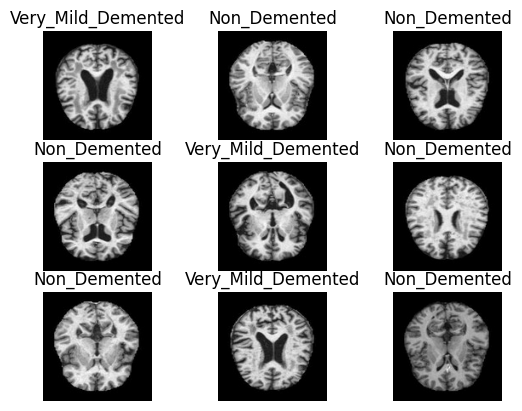

In [13]:
# Mostrar las primeras 9 fotos del primer batch, desplegarlas y mostrar la etiqueta correspondiente.

for images, labels in train_ds.take(1): #tomar primer batch
    for i in range(9):
        image = images[i]
        label = labels[i]

        # Convertir de one hot encoded a respectiva clase
        class_index = tf.argmax(label)
        class_name = class_names[class_index]

        plt.subplot(3, 3, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(class_name)
        plt.axis("off")

plt.show()


El image_batch es un tensor de la forma (32, 128, 128, 3). Lo que quiere decir que es un batch de 32 imágenes de tamaño 128 x 128 x 3.  Así mismo, label_batch es un tensor de la forma (32, 4) correspondiente a las etiquetas de las 32 imágenes de 4 clases.

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32, 4)


# Modelo 1

Al ser las imágenes de dimensión 128 x 128 x 3, se indica que es RGB, dichos valores están en el rango [0, 255] . Esto no es ideal para una red neuronalse debe buscar que sus valores de entrada sean pequeños. Por ende, en el modelo se estandarizará los valores para que estén en el rango [0, 1].

EL modelo está compuesto de la siguiente forma:
* Rescaling en el rango [0, 1]
* Capa de convolución
* Max pooling
* Capa de convolución
* Max pooling
* Flatten
* Capa densa

La selección de la cantidad de filtros en las capas de convolución va incrementado como se puede notar (16 y luego 32) , esto es debido a que las capas más superficiales suelen detecatr aptrones de bajo nivel como bordes, mientras que las capas más profundas y complejas aprenden patrones más robustos. Así mismo en todos los casos el kernel es de 3x3, queremos que la imagen se mantenga del mismo tamaño, por lo que el padding = 'same'. Finalmente, las activación que se selecionó es 'relu' ya que al introducir no linealidad puede aprender patrones más complejos.

Para la capa de MaxPooling2D indica que utiliza un filtro de 2x2 para realizar la agrupación máxima y reducir dimensionalidad.

Posteriormente se pasa a una capa flatten para cambiar la estructura a un solo vector que se pasará a la capap densa totalmente conectada que clasificará. Esta capa densa tendrá la misma cantidad de neuronas que de clases ya que representa la probabilidad de que pertenezca a dicha clase. Para esta capa de salida se utiliza la función de activación 'softmax' ya que es un clasificación multiclase.

In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras import layers
num_classes = 4

model = Sequential([
  layers.Rescaling(1./255, input_shape=(128, 128, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2),
  layers.Flatten(),
  layers.Dense(num_classes, activation='softmax')
])

Se establece un early stopping donde el mínimo cambio de mejora sea de 0.015 en el accuracy, y si el modelo no presenta mejora por dos épocas seguidas, el entrenamiento para.

Así mismo se utiliza como optimizador Adam con learning rate = 0.0005, las función de pérdida 'categorical_crossentropy' ya que es multiclase y están codificadas en one hot  y como métrica de evaluación 'accuracy' y 'mse'.

Posteriomente, se corre el modelo con 20 épocas base, pero parará antes si ya no encuentra mejora significativa.

In [17]:
callback=tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",
    min_delta=0.015,
    patience=2,
    verbose=1,
    mode="auto",
    baseline=0.8,
    restore_best_weights=False)

In [18]:
opt = tf.keras.optimizers.Adam(learning_rate=.0005)
mae = tf.keras.metrics.MeanAbsoluteError()

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', mae])
# since i am using one hot encoded lables from my label_mode = 'categorical'

In [19]:
history = model.fit(train_ds, validation_data= val_ds, epochs=20, callbacks=[callback])

Epoch 1/20
144/144 [==============================] - 71s 466ms/step - loss: 0.9801 - accuracy: 0.5316 - mean_absolute_error: 0.2872 - val_loss: 0.8904 - val_accuracy: 0.5525 - val_mean_absolute_error: 0.2521
Epoch 2/20
144/144 [==============================] - 54s 376ms/step - loss: 0.7933 - accuracy: 0.6432 - mean_absolute_error: 0.2419 - val_loss: 0.6944 - val_accuracy: 0.7101 - val_mean_absolute_error: 0.2272
Epoch 3/20
144/144 [==============================] - 52s 361ms/step - loss: 0.5844 - accuracy: 0.7583 - mean_absolute_error: 0.1903 - val_loss: 0.5301 - val_accuracy: 0.7549 - val_mean_absolute_error: 0.1785
Epoch 4/20
 86/144 [================>.............] - ETA: 21s - loss: 0.4140 - accuracy: 0.8496 - mean_absolute_error: 0.1409

KeyboardInterrupt: ignored

Se corrieron 13 épocas en las que hubo cambios significativos en el accuracy

In [ ]:
import pandas as pd
df = pd.DataFrame(history.history)
df

Podemos apreciar como la pérdida va disminuyendo a lo alrgho de cada época. Así mismo, el accuracy y el accuracy del set de validación incrementan y en las últimas épocas se puede ver cómo se mantiene similar tanto accuracy de entrenamiento como de validación por lo que podría sugerir que no presenta overfitting.

In [ ]:
# Make a plot for the loss
df.plot(y=["loss", "val_loss"], title="Loss vs Epoch")

In [ ]:
# Make a plot for the accuracy

df.plot(y=["accuracy", "val_accuracy"], title="categorical_accuracy vs Epoch")

## Predicciones

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
predictions = []
true_labels = []

for images, labels in test_ds:
    predictions_batch = model.predict(images)
    predictions.extend(predictions_batch)
    true_labels.extend(labels)


predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(true_labels, axis=1)

# Classification report
confusion_mat = classification_report(true_classes, predicted_classes)
print(confusion_mat)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(true_classes, predicted_classes)
print(confusion_mat)

Como podemos observar, las métricas del reporte de clasificación presnetan excelentes resultados. Al revisar las predicciones, podemos observar cómo 20 'Very_Mild_Demnted' los clasificó como 'Non_Demented'. Del modo contrario, 9 'Non_Demented' los clasificó como 'Very_Mild_Demented'. Así mismo 12 imágenes las categoriza como 'Mild Demented' mientras que son incorrectas.

# Ajuste de modelo

## Modelo 2 : Batch Normalization

El primer cambio que se hará, será introducir una capa de Batch Normalization para normalizar la entrada y ayudar a que converja más rápido. También se hizo el cambio de dejar solo una capa de convolución.

Todo lo demás permanece igual.


In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras import layers

In [16]:
callback=tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",
    min_delta=0.015,
    patience=2,
    verbose=1,
    mode="auto",
    baseline=0.8,
    restore_best_weights=False)

In [19]:
num_classes = 4

model2 = Sequential([
  layers.Rescaling(1./255, input_shape=(128, 128, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu', use_bias = False),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2),
  layers.Flatten(),
  layers.Dense(num_classes, activation='softmax')
])

In [20]:
opt = tf.keras.optimizers.Adam(learning_rate=.0005)
mae = tf.keras.metrics.MeanAbsoluteError()

model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', mae])

In [21]:
history2 = model2.fit(train_ds, validation_data= val_ds, epochs=15,  callbacks=[callback])

Epoch 1/15
144/144 [==============================] - 15s 24ms/step - loss: 1.4576 - accuracy: 0.6015 - mean_absolute_error: 0.2232 - val_loss: 0.8855 - val_accuracy: 0.5623 - val_mean_absolute_error: 0.2675
Epoch 2/15
144/144 [==============================] - 2s 16ms/step - loss: 0.3214 - accuracy: 0.8749 - mean_absolute_error: 0.0999 - val_loss: 0.7520 - val_accuracy: 0.7218 - val_mean_absolute_error: 0.2283
Epoch 3/15
144/144 [==============================] - 2s 14ms/step - loss: 0.1216 - accuracy: 0.9642 - mean_absolute_error: 0.0448 - val_loss: 0.4157 - val_accuracy: 0.8288 - val_mean_absolute_error: 0.1391
Epoch 4/15
144/144 [==============================] - 2s 14ms/step - loss: 0.0447 - accuracy: 0.9939 - mean_absolute_error: 0.0193 - val_loss: 0.2225 - val_accuracy: 0.9339 - val_mean_absolute_error: 0.0774
Epoch 5/15
144/144 [==============================] - 2s 13ms/step - loss: 0.0236 - accuracy: 0.9989 - mean_absolute_error: 0.0109 - val_loss: 0.1224 - val_accuracy: 0.970

In [23]:
import pandas as pd
df2 = pd.DataFrame(history2.history)
df2

,loss,accuracy,mean_absolute_error,val_loss,val_accuracy,val_mean_absolute_error
0,1.457618,0.601520,0.223245,0.885508,0.562257,0.267474
1,0.321413,0.874919,0.099913,0.752048,0.721790,0.228322
2,0.121605,0.964169,0.044763,0.415651,0.828794,0.139099
3,0.044693,0.993920,0.019264,0.222459,0.933852,0.077425
4,0.023599,0.998914,0.010853,0.122351,0.970817,0.042196
5,0.011643,1.000000,0.005676,0.093795,0.978599,0.029411


Comparando la gráfica de accuracy con el modelo 1, este modelo presenta resultados de accuracy más estables en las últimas épocas llegando a casi un plateau. Si el accuracy aumenta, también el validation accuracy, por lo que probablemnte no haya overfitting.

<Axes: title={'center': 'categorical_accuracy vs Epoch'}>

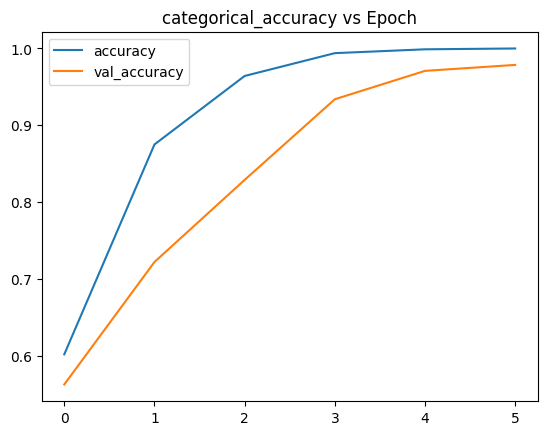

In [24]:

df2.plot(y=["accuracy", "val_accuracy"], title="categorical_accuracy vs Epoch")

In [ ]:
# Make a plot for the loss
df2.plot(y=["loss", "val_loss"], title="Loss vs Epoch")

### Predicciones


In [ ]:
predictions = []
true_labels = []

for images, labels in test_ds:
    predictions_batch = model2.predict(images)
    predictions.extend(predictions_batch)
    true_labels.extend(labels)


predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(true_labels, axis=1)

# Classification report
confusion_mat = classification_report(true_classes, predicted_classes)
print(confusion_mat)

Como podemos observar, las métricas del reporte de clasificación presentan excelentes resultados, incluso mejores que el modelo anterior. La única métrica que permanece un poco por debajo es recall.



In [ ]:
confusion_mat = confusion_matrix(true_classes, predicted_classes)
print(confusion_mat)

 Al revisar las predicciones, podemos observar cómo 8 'Very_Mild_Demnted' los clasificó como 'Non_Demented'. Del modo contrario, 10 'Non_Demented' los clasificó como 'Very_Mild_Demented'. Así mismo 6 imágenes las categoriza como 'Mild Demented' mientras que son incorrectas.

 A partir de esto, podemos apreciar cómo mejora este modelo. No solo presenta accuracy y loss mucho mejor. Las predicciones también son muy buenas, se reducen la cantidad total de predicciones incorrectas. Así mismo, el caso que consideraría más grave, de diagnosticar a alguien con Alzheimer como 'Non_Demented' reduce considerablemente de 20 casos a 8 casos.

## Modelo 3: Linear regularization and early stopping

Para esta corrida introduciremos la regularización lineal L1L2 para, a pesar de no presentar indicios considerables de overfitting, se ayudaría a evitarlo.

Así mismo, continuaré con el modelo previamente utilizado el cual posee batch normalization. El único cambio será agregar regularización lineal en la capa de convolución.


In [ ]:
from tensorflow.keras import regularizers

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
callback=tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",
    min_delta=0.015,
    patience=2,
    verbose=1,
    mode="auto",
    baseline=0.8,
    restore_best_weights=False)

In [ ]:
model3 = Sequential([
  layers.Rescaling(1./255, input_shape=(128, 128, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.03)),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2),
  layers.Flatten(),
  layers.Dense(num_classes, activation='softmax')
])

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=.0005)
mae = tf.keras.metrics.MeanAbsoluteError()
model3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', mae])
history = model3.fit(train_ds, validation_data= val_ds, epochs=15, callbacks=[callback])

In [ ]:
df3 = pd.DataFrame(history.history)
df3

In [ ]:
df3.plot(y=["accuracy", "val_accuracy"], title="categorical_accuracy vs Epoch")

In [ ]:
df3.plot(y=["loss", "val_loss"], title="Loss vs Epoch")

A pesar de implementar regularización, se puede observar que el modelo 2 presenta mejores resultados. No solo muestra menores variaciones en las gráficas y comportamientos más similares entre trainning accuracy y validation accuracy, también posee menores pérdidas y mayores accuracy el modelo 2 vs modelo 3.

### Predicciones

In [ ]:
predictions = []
true_labels = []

for images, labels in test_ds:
    predictions_batch = model3.predict(images)
    predictions.extend(predictions_batch)
    true_labels.extend(labels)


predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(true_labels, axis=1)

# Classification report
confusion_mat = classification_report(true_classes, predicted_classes)
print(confusion_mat)

Como podemos observar, las métricas del reporte de clasificación presentan buenos resultados, pero no mejores que el modelo anterior.

In [ ]:
confusion_mat = confusion_matrix(true_classes, predicted_classes)
print(confusion_mat)

 Al revisar las predicciones, podemos observar cómo 2 'Very_Mild_Demnted' los clasificó como 'Non_Demented'. Del modo contrario, 29 'Non_Demented' los clasificó como 'Very_Mild_Demented'. Así mismo 9 imágenes las categoriza como 'Mild Demented' mientras que son incorrectas.

 A partir de esto, podemos apreciar cómo es un bastante buen modelo que posee pocos errores. Sin emabrgo, podemos ver cómo el modelo tiende a clasificar como Demented aquellos pacientes que son Non_Demented.


# Análisis de resultados


 La elección de modelo dependerá de los fines y prioridades del problema. Por ejemplo, si nos interesa que haya el menor número de pacientes que poseen la enfermedad pero que sean clasificados como que no la poseen, será mejor el tercer modelo.

 Sin embargo, si se desea un modelo más estable, que overall posee menos cantidad de errores, mejores métricas, menor pérdida y poco indicio de overfitting, recomendaría el segundo modelo. Por ende, en mi opinión sería mejor quedarse con el segundo modelo.

 Dicho modelo posee un accuracy de validación de 0.990625

In [ ]:
predictions = []
true_labels = []

for images, labels in test_ds:
    predictions_batch = model2.predict(images)
    predictions.extend(predictions_batch)
    true_labels.extend(labels)


predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(true_labels, axis=1)

# Classification report
confusion_mat = classification_report(true_classes, predicted_classes)
print(confusion_mat)

 Así, el mejopr modelo presentó:

*  8 'Very_Mild_Demnted' los clasificó como 'Non_Demented'.
* Del modo contrario, 10 'Non_Demented' los clasificó como 'Very_Mild_Demented'.
* Así mismo 6 imágenes las categoriza como 'Mild Demented' mientras que son incorrectas.

Como se puede observar, todavía queda trabajo por hacer respecto a la correcta clasificación de las imágenes.
A pesar de presentar excelentes resultados, se podría intentar utilizar transfer learning para ver si el modelo podría mejorar más respectoa  estos errores o si por el contrario tiene mejor rendimiento con arquitecturas más sencillas.

## Predicciones con imágenes nuevas
Este apartado permite subir imágenes externas y hacer predicciones de manera sencilla.

En este ejmeplo se obtuve la imágen del cerebro RMI y de la siguiente liga:
https://link.springer.com/article/10.1007/s00415-018-9016-3

La imágen original presenta 3 divisiones con 3 cerebros correspondientes a si es un cerebro normal o demented. Para este caso recorté solo el cerebro original el cuál corresponde a la imágen siguiente:


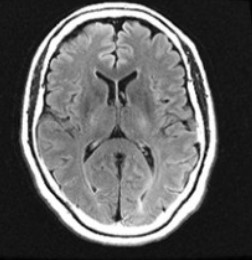



Para la parte de predicciones, solo se solicita al usuario que copie la ruta de la imágen que quiera clasificar y las funciones hacen las transformaciones correspondientes para poder convertir la imágen a un arreglo y posteriormente utilizar el modelo 2 para hacer las predicciones y regresar la clase correspondiente.

In [29]:
from tensorflow.keras.preprocessing import image
import numpy as np

def ajuste_imagen(img_path):
  img = image.load_img(img_path, target_size=(128, 128))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array = img_array / 255.0
  return img_array

def prediccion(img_array):
  clase = ['mild', 'moderated', 'non_demented', 'very_mild_demented']
  predictions = model2.predict(img_array)
  predicted_class = np.argmax(predictions)
  print("Clase predicha:", clase[predicted_class-1])


In [33]:
# Cambie la ruta a la imágen que quiere clasificar

img_path = '/content/Captura de pantalla 2023-11-29 122338.png'


1/1 [==============================] - 0s 28ms/step
Clase predicha: non_demented
